In [ ]:
from echo.openfast_io_overload import InputReader_OpenFAST, InputWriter_OpenFAST
from openfast_io.FAST_output_reader import FASTOutputFile
from scipy import fft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [41]:
# Extracting the data from the OpenFAST output file
data = FASTOutputFile('/Users/mchetan/Desktop/nrel/projects/3-STABLE/tools/echo/tests/simplifiedTurbine/fa-nacelle/simpleTurbine.out')

dataDF = data.toDataFrame()

In [42]:
dataDF['B1N005_TVxr_[m/s]']

0         0.000000e+00
1         1.091740e-07
2         4.100695e-07
3         9.797694e-07
4         1.882812e-06
              ...     
499996    4.678546e-03
499997    4.668473e-03
499998    4.658398e-03
499999    4.648321e-03
500000    4.638241e-03
Name: B1N002_TVxr_[m/s], Length: 500001, dtype: float64

## Data Trimming

Let's trim the first 101 seconds of data to remove initial transients:

Original data length: 500001 points, starting at 0.000s, ending at 500.000s
Trimmed data length: 399001 points, starting at 0.000s, ending at 399.000s


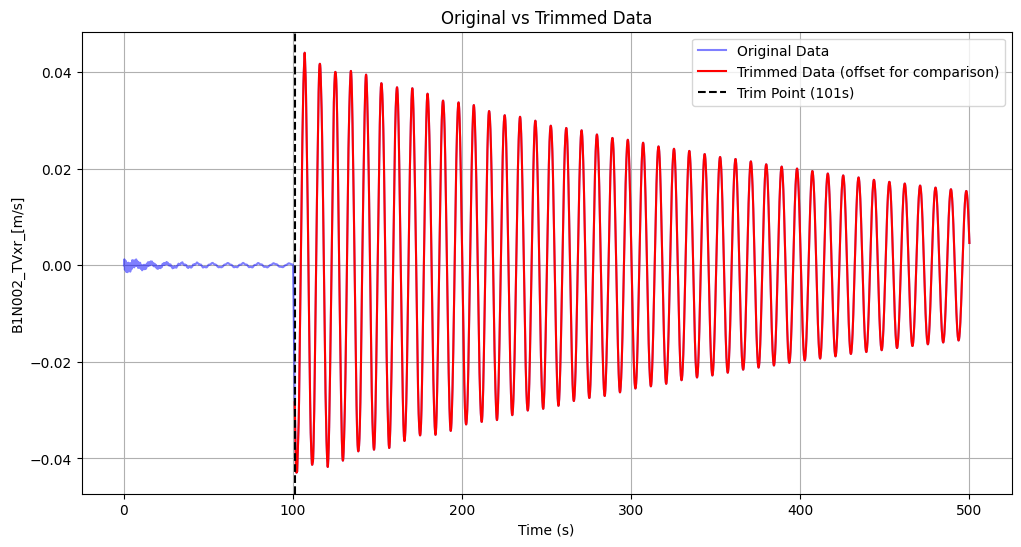

In [ ]:
# Get time column and determine the 101s mark index
time_column = dataDF['Time_[s]']
trim_index = np.argmin(np.abs(time_column - 101.0))

# Trim the data
trimmed_dataDF = dataDF.iloc[trim_index:].copy()

# Reset time to start from 0
trimmed_dataDF['Time_[s]'] = trimmed_dataDF['Time_[s]'] - trimmed_dataDF['Time_[s]'].iloc[0]

print(f"Original data length: {len(dataDF)} points, starting at {dataDF['Time_[s]'].iloc[0]:.3f}s, ending at {dataDF['Time_[s]'].iloc[-1]:.3f}s")
print(f"Trimmed data length: {len(trimmed_dataDF)} points, starting at {trimmed_dataDF['Time_[s]'].iloc[0]:.3f}s, ending at {trimmed_dataDF['Time_[s]'].iloc[-1]:.3f}s")

# Create interactive Plotly figure comparing original and trimmed data
fig = go.Figure()

# Add original data trace
fig.add_trace(
    go.Scatter(
        x=dataDF['Time_[s]'],
        y=dataDF['B1N002_TVxr_[m/s]'],
        mode='lines',
        name='Original Data',
        line=dict(color='blue', width=1, dash='solid')
    )
)

# Add trimmed data trace (offset for comparison)
fig.add_trace(
    go.Scatter(
        x=trimmed_dataDF['Time_[s]'] + 101,  # Add 101s offset for comparison
        y=trimmed_dataDF['B1N002_TVxr_[m/s]'],
        mode='lines',
        name='Trimmed Data (offset)',
        line=dict(color='red', width=1.5)
    )
)

# Add a vertical line at the trim point
fig.add_vline(x=101, line_width=2, line_dash="dash", line_color="black",
              annotation_text="Trim Point (101s)", annotation_position="top right")

# Update layout
fig.update_layout(
    title='Original vs Trimmed Data',
    xaxis_title='Time (s)',
    yaxis_title='B1N002_TVxr_[m/s]',
    legend_title='Dataset',
    hovermode='closest',
    height=500,
    width=900,
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

In [44]:
# Perform FFT on the trimmed data instead of original data
x = fft.fft(np.array(trimmed_dataDF['B1N002_TVxr_[m/s]']))

magnitude = np.abs(x)  # Magnitude of each frequency component
phase = np.angle(x)  # Phase of each frequency component

fs = 1 / 0.001  # Sampling frequency

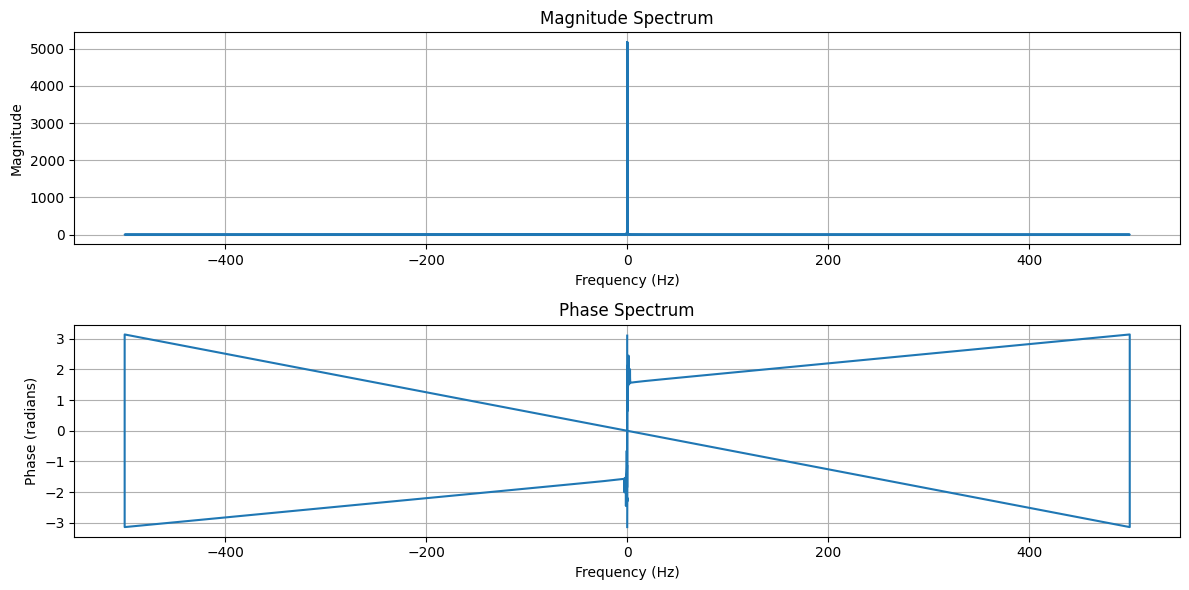

In [45]:
# Get the frequency axis
freq = fft.fftfreq(x.shape[-1], d=1/fs)  # Or numpy.fft.fftfreq

# Plot magnitude
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq, magnitude)
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()

# Plot phase
plt.subplot(2, 1, 2)
plt.plot(freq, phase)
plt.title("Phase Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid()

plt.tight_layout()
plt.show()


## Corrected FFT Analysis

The plot above shows both positive and negative frequencies, which is normal for FFT output but can be confusing.
For real-valued signals, we typically only need the positive frequencies (first half of the FFT output).
Let's plot just the positive frequency components:

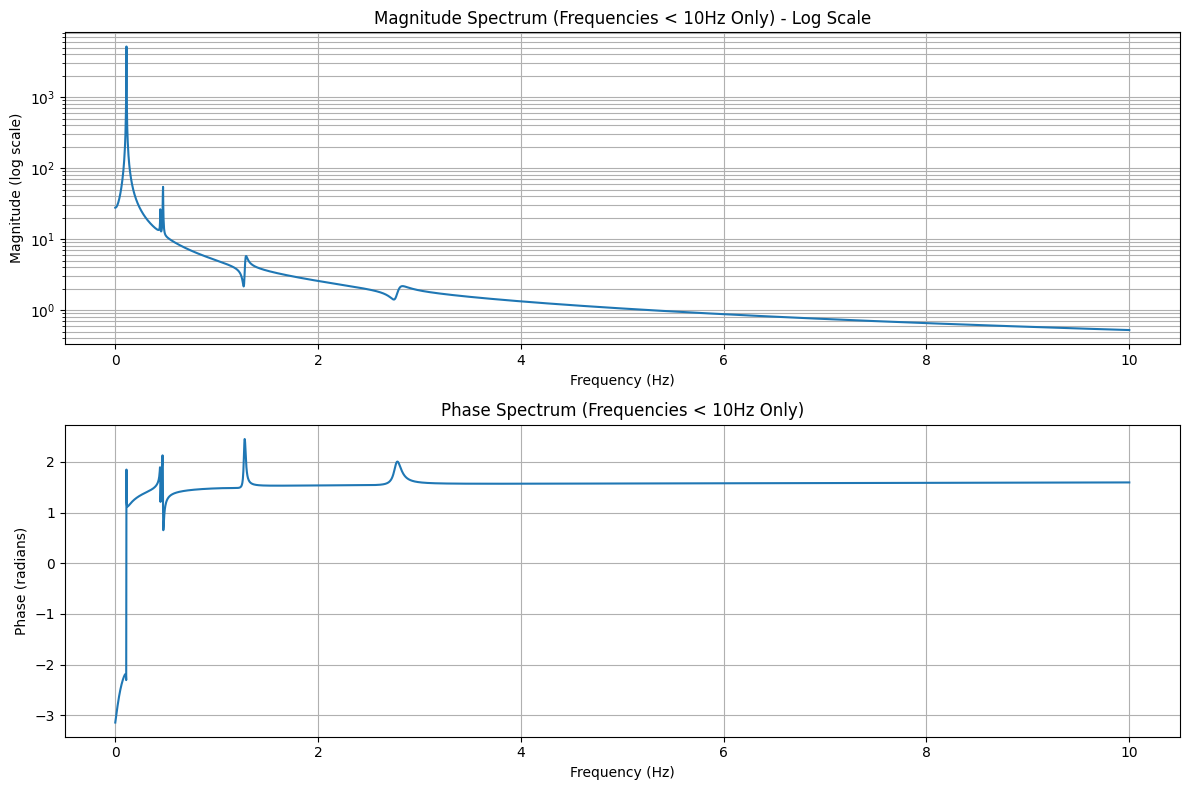

In [46]:
# Get the positive frequency components (first half of the FFT output)
n = len(x)
pos_freq = freq[:n//2]  # Only positive frequencies
pos_magnitude = magnitude[:n//2]  # Corresponding magnitudes
pos_phase = phase[:n//2]  # Corresponding phases

# Filter for frequencies < 10Hz
below_10hz_mask = pos_freq < 10
freq_below_10hz = pos_freq[below_10hz_mask]
magnitude_below_10hz = pos_magnitude[below_10hz_mask]
phase_below_10hz = pos_phase[below_10hz_mask]

# Plot frequencies < 10Hz only
plt.figure(figsize=(12, 8))

# Plot magnitude (frequencies < 10Hz only) using log scale
plt.subplot(2, 1, 1)
plt.semilogy(freq_below_10hz, magnitude_below_10hz)
plt.title("Magnitude Spectrum (Frequencies < 10Hz Only) - Log Scale")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (log scale)")
plt.grid(True, which="both", ls="-")

# Plot phase (frequencies < 10Hz only)
plt.subplot(2, 1, 2)
plt.plot(freq_below_10hz, phase_below_10hz)
plt.title("Phase Spectrum (Frequencies < 10Hz Only)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)

plt.tight_layout()
plt.show()

## Explanation of Phase Behavior

The phase plot appears "undefined" or noisy for several reasons:

1. **Low magnitude components**: When a frequency component has very low magnitude (close to noise level), its phase becomes essentially random.

2. **Phase wrapping**: Phase values are limited to the range [-π, π]. When the true phase exceeds these bounds, it "wraps around", causing discontinuities.

3. **Numerical precision**: For very small magnitude components, numerical precision issues can affect phase calculations.

Let's create a modified phase plot that only shows phases for frequency components with significant magnitudes:

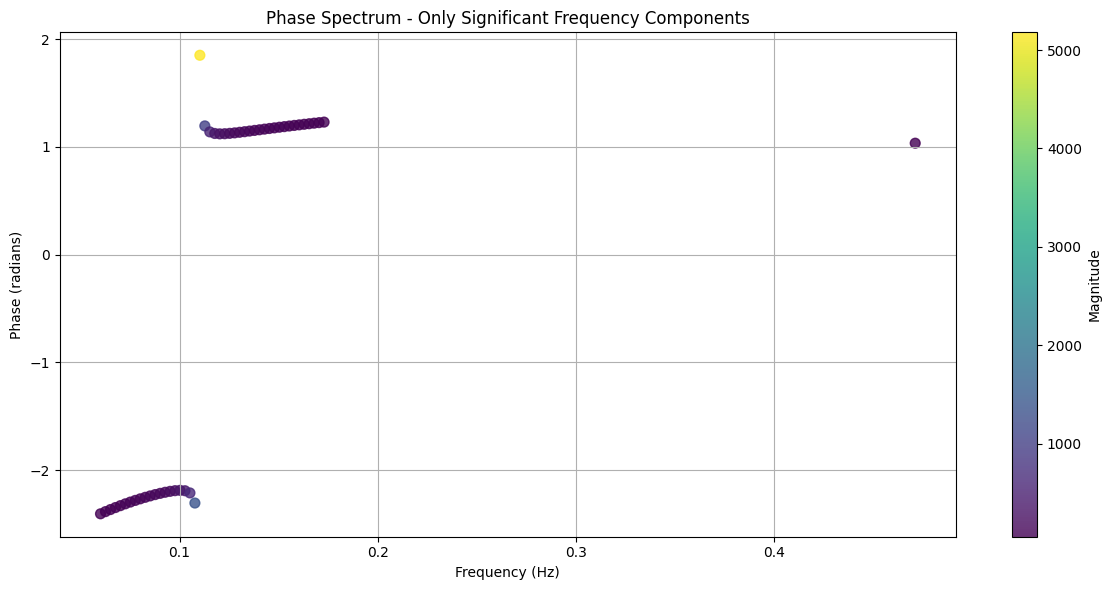

In [47]:
# Create threshold for significant magnitude components (e.g., 1% of max)
magnitude_threshold = 0.01 * np.max(magnitude_below_10hz)

# Create mask for significant components
significant_mask = magnitude_below_10hz > magnitude_threshold

# Plot only phases for significant frequency components
plt.figure(figsize=(12, 6))

# Plot filtered phase
plt.scatter(freq_below_10hz[significant_mask], phase_below_10hz[significant_mask], 
           c=magnitude_below_10hz[significant_mask], cmap='viridis', s=50, alpha=0.8)

plt.colorbar(label='Magnitude')
plt.title("Phase Spectrum - Only Significant Frequency Components")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Finding Prominent Frequencies Below 10Hz

Let's identify the most significant frequency components below 10Hz in the signal:

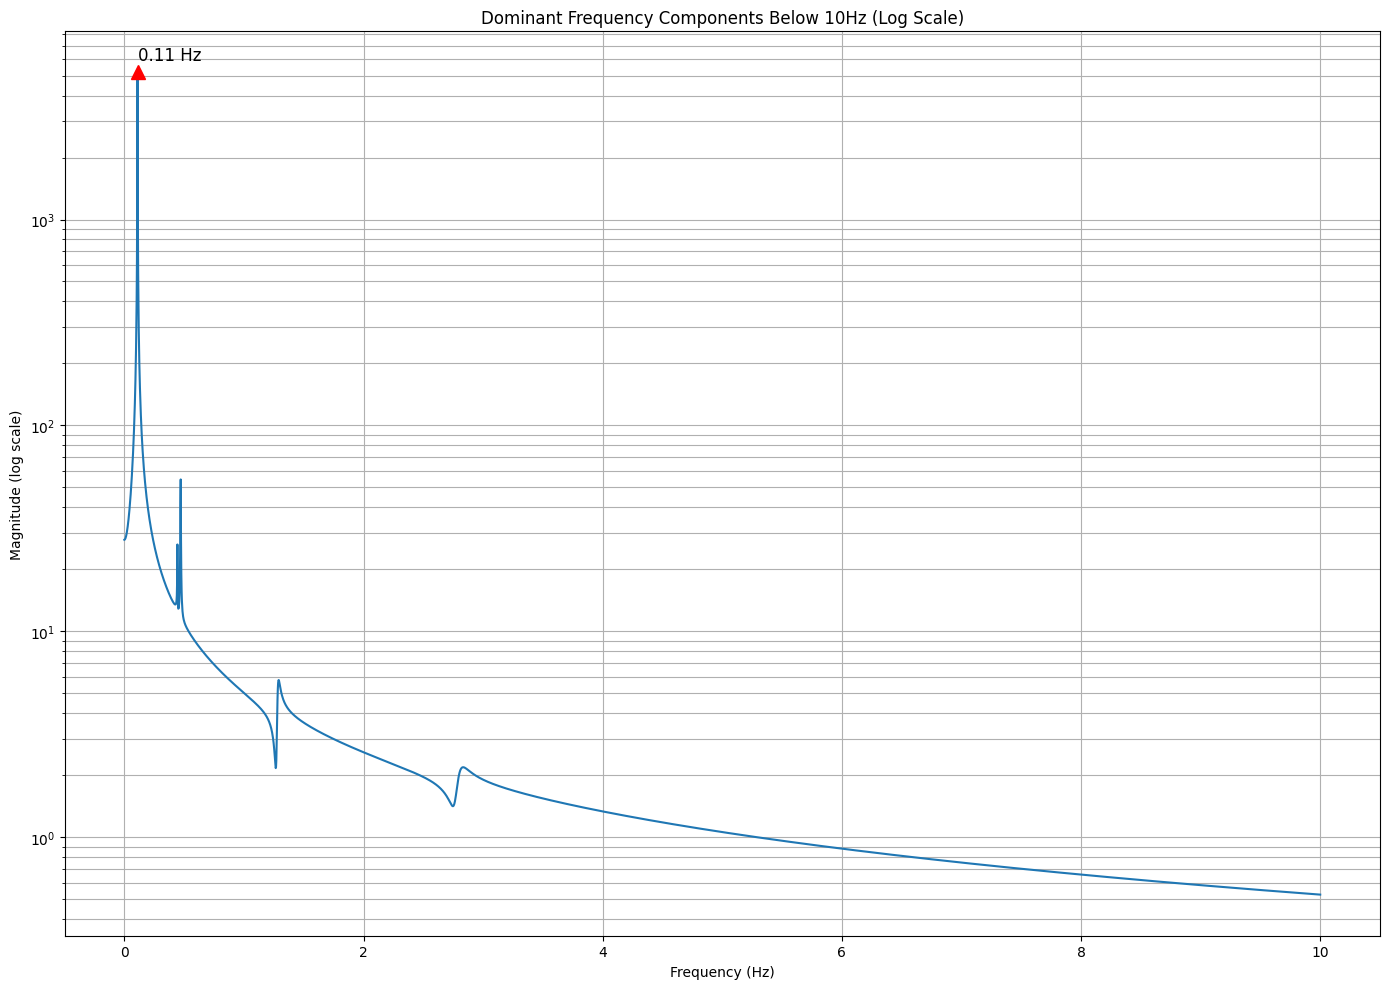

Dominant frequencies below 10Hz:
0.11 Hz with magnitude 5180.04


In [48]:
# Find peaks in the magnitude spectrum below 10Hz
from scipy.signal import find_peaks

# Find peaks with prominence at least 10% of max magnitude
threshold = 0.1 * np.max(magnitude_below_10hz)
peaks, _ = find_peaks(magnitude_below_10hz, height=threshold)

# Plot frequencies < 10Hz with peak identification (log scale)
plt.figure(figsize=(14, 10))

plt.semilogy(freq_below_10hz, magnitude_below_10hz)
plt.semilogy(freq_below_10hz[peaks], magnitude_below_10hz[peaks], 'r^', markersize=10)

# Add labels for peak frequencies
for i, peak in enumerate(peaks):
    plt.text(freq_below_10hz[peak], magnitude_below_10hz[peak] * 1.1, 
             f"{freq_below_10hz[peak]:.2f} Hz", 
             fontsize=12, verticalalignment='bottom')

plt.title("Dominant Frequency Components Below 10Hz (Log Scale)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (log scale)")
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.show()

# Print the identified peak frequencies
print("Dominant frequencies below 10Hz:")
for peak in peaks:
    print(f"{freq_below_10hz[peak]:.2f} Hz with magnitude {magnitude_below_10hz[peak]:.2f}")

## Enhanced Spectral Analysis with Welch Method

Let's implement a more sophisticated spectral analysis using:
- **Type**: Power Spectral Density (PSD)
- **Averaging Method**: Welch
- **Window**: Hamming
- **Segment Size**: 2^18 (262144)
- **Frequency Limit**: 5 Hz
- **Signal Processing**: Detrend
- **Phase Analysis**: Included

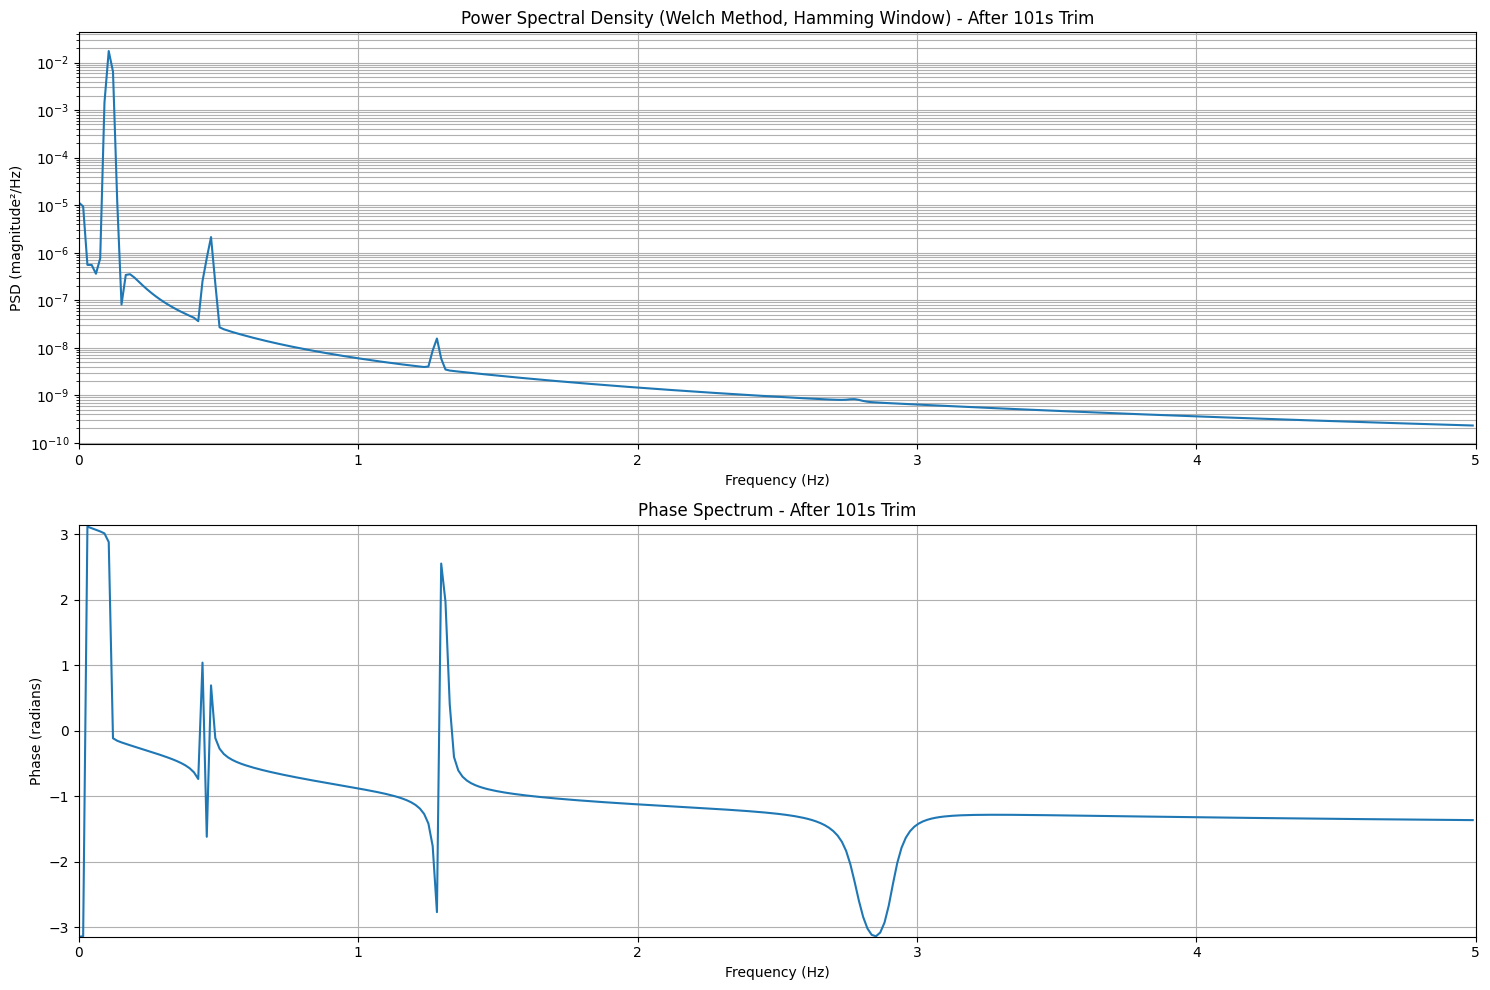

In [49]:
from scipy import signal

# Extract the signal data from trimmed dataset
signal_data = np.array(trimmed_dataDF['B1N002_TVxr_[m/s]'])

# Detrend the signal - remove linear trend
detrended_data = signal.detrend(signal_data)

# Calculate sampling frequency
fs = 1 / 0.001  # Assuming 0.001s time step as before

# Calculate PSD using Welch's method with Hamming window
# Using 2^16 = 65536 for segment size (or maximum possible)
nperseg = min(2**16, len(detrended_data))  # In case data is shorter than 2^16
frequencies, psd = signal.welch(detrended_data, fs=fs, window='hamming', 
                               nperseg=nperseg, scaling='density')

# Get phase information from FFT (not directly provided by Welch)
# We need to compute FFT on the same detrended data
n_fft = min(2**16, len(detrended_data))
fft_result = fft.fft(detrended_data, n=n_fft)
fft_freqs = fft.fftfreq(n_fft, d=1/fs)
fft_phase = np.angle(fft_result)

# Filter frequencies below 5 Hz
mask = frequencies <= 5.0
freq_filtered = frequencies[mask]
psd_filtered = psd[mask]

# Filter FFT frequencies and phase to match PSD frequencies
pos_mask = fft_freqs >= 0
fft_freqs_pos = fft_freqs[pos_mask]
fft_phase_pos = fft_phase[pos_mask]

# Interpolate phase to match PSD frequency points (since they may differ slightly)
from scipy.interpolate import interp1d
# Filter out frequencies outside our range and only use positive frequencies
phase_mask = (fft_freqs_pos <= 5.0) & (fft_freqs_pos >= 0)
phase_interp = interp1d(fft_freqs_pos[phase_mask], fft_phase_pos[phase_mask], 
                      kind='linear', bounds_error=False, fill_value=np.nan)

# Get phase values at PSD frequency points
phase_at_psd_freqs = phase_interp(freq_filtered)

# Plot both representations
plt.figure(figsize=(15, 10))

# Plot 1: Standard PSD vs Frequency with logarithmic y-axis
plt.subplot(2, 1, 1)
plt.semilogy(freq_filtered, psd_filtered)
plt.title("Power Spectral Density (Welch Method, Hamming Window) - After 101s Trim")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (magnitude²/Hz)")
plt.grid(True, which="both", ls="-")
plt.xlim(0, 5)

# Plot 2: Phase vs Frequency
plt.subplot(2, 1, 2)
valid_phase = ~np.isnan(phase_at_psd_freqs)
plt.plot(freq_filtered[valid_phase], phase_at_psd_freqs[valid_phase])
plt.title("Phase Spectrum - After 101s Trim")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(-np.pi, np.pi)

plt.tight_layout()
plt.show()

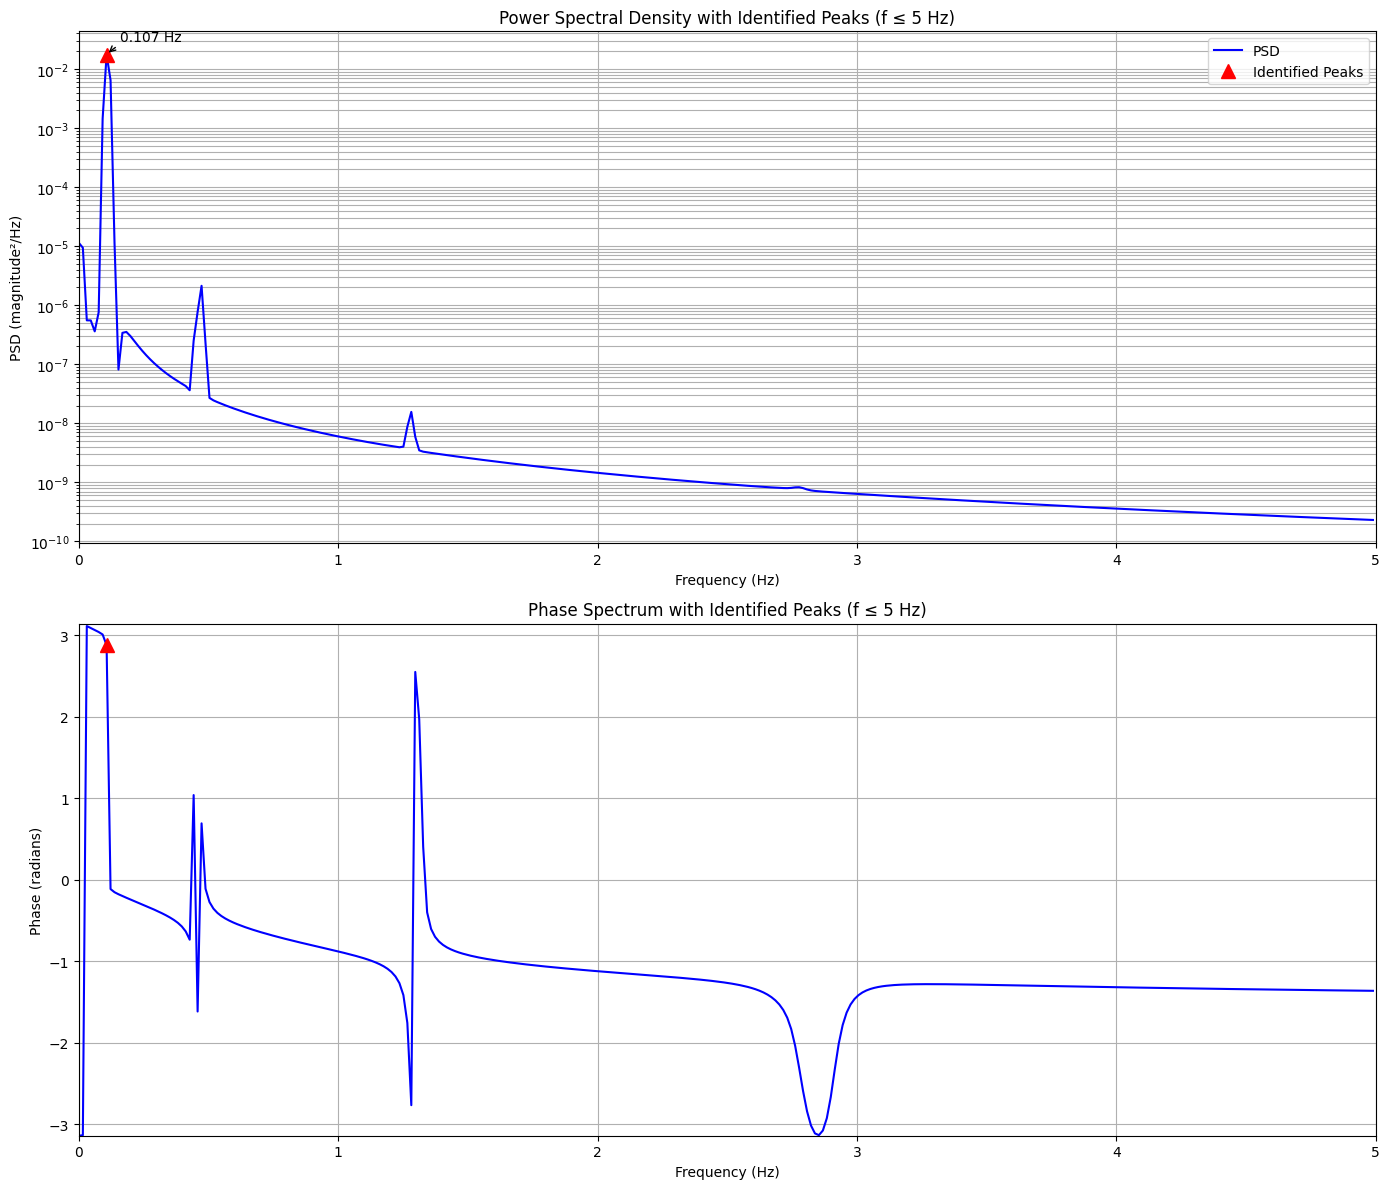

Identified frequency peaks:
--------------------------
Frequency (Hz)  Magnitude (PSD)      Phase (rad)    
--------------------------------------------------
0.1068          1.7540e-02           2.8790         


In [50]:
# Find peaks in the PSD
from scipy.signal import find_peaks

# Parameters for peak finding
prominence_factor = 0.05  # Adjust this for different sensitivity
prominence = prominence_factor * np.max(psd_filtered)

# Find peaks
peaks, properties = find_peaks(psd_filtered, prominence=prominence)

# Create a figure with PSD and Phase plots showing identified peaks
plt.figure(figsize=(14, 12))

# Plot PSD with peaks
plt.subplot(2, 1, 1)
plt.semilogy(freq_filtered, psd_filtered, 'b-', linewidth=1.5, label='PSD')
plt.semilogy(freq_filtered[peaks], psd_filtered[peaks], 'r^', markersize=10, label='Identified Peaks')

# Add labels for peak frequencies
for i, peak in enumerate(peaks):
    plt.annotate(f"{freq_filtered[peak]:.3f} Hz", 
                xy=(freq_filtered[peak], psd_filtered[peak]),
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.title("Power Spectral Density with Identified Peaks (f ≤ 5 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (magnitude²/Hz)")
plt.grid(True, which="both", ls="-")
plt.xlim(0, 5)
plt.legend()

# Plot Phase with peaks
plt.subplot(2, 1, 2)
plt.plot(freq_filtered[valid_phase], phase_at_psd_freqs[valid_phase], 'b-', linewidth=1.5)

# Mark phase values at the peak frequencies
peak_phases = [phase_at_psd_freqs[p] if p < len(phase_at_psd_freqs) and not np.isnan(phase_at_psd_freqs[p]) else np.nan for p in peaks]
valid_peak_phases = ~np.isnan(peak_phases)
plt.plot(freq_filtered[peaks][valid_peak_phases], np.array(peak_phases)[valid_peak_phases], 'r^', markersize=10)

plt.title("Phase Spectrum with Identified Peaks (f ≤ 5 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(-np.pi, np.pi)

plt.tight_layout()
plt.show()

# Print results in a readable format
print("Identified frequency peaks:")
print("--------------------------")
print(f"{'Frequency (Hz)':<15} {'Magnitude (PSD)':<20} {'Phase (rad)':<15}")
print("-" * 50)
for i, peak in enumerate(peaks):
    freq = freq_filtered[peak]
    power = psd_filtered[peak]
    phase_val = peak_phases[i] if i < len(peak_phases) else np.nan
    phase_str = f"{phase_val:.4f}" if not np.isnan(phase_val) else "N/A"
    print(f"{freq:<15.4f} {power:<20.4e} {phase_str:<15}")

## Enhanced Phase Analysis for Major Frequency Components

Let's focus on getting clearer phase information for the most significant frequency components:

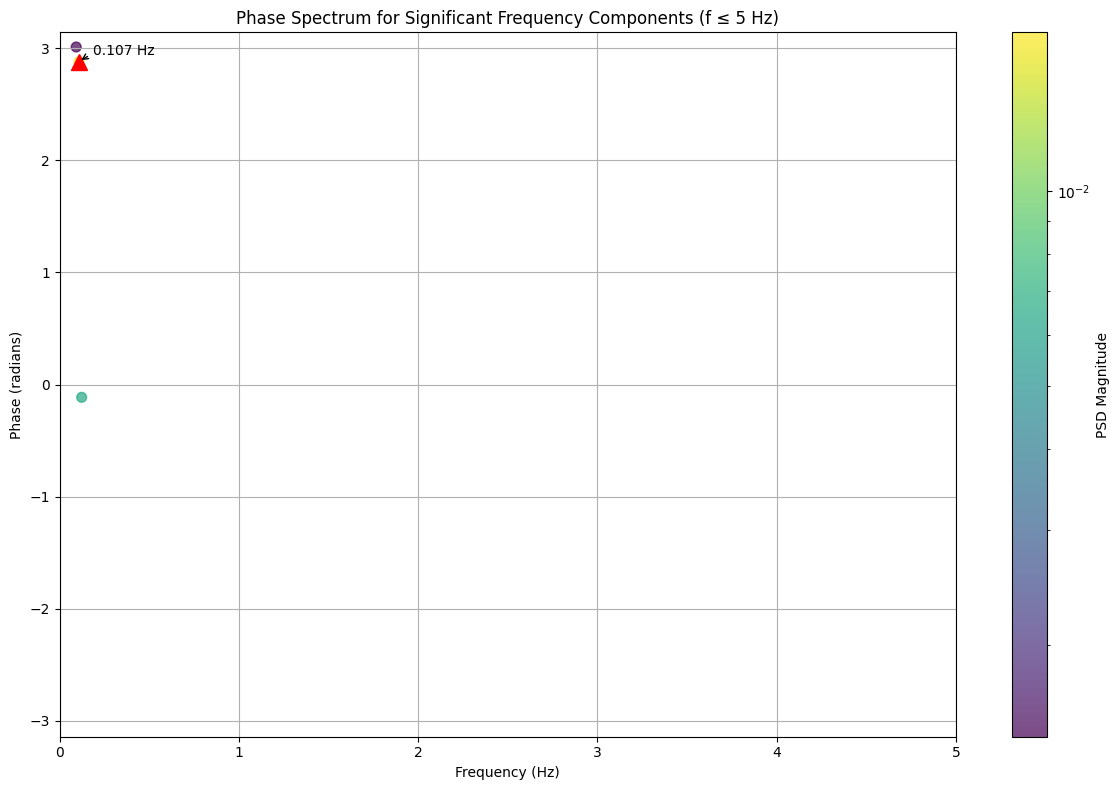

In [51]:
# Filter for significant components only
psd_threshold = 0.01 * np.max(psd_filtered)  # 1% of max PSD
significant_mask = psd_filtered > psd_threshold

# Scatter plot of phase for significant components
plt.figure(figsize=(12, 8))
sc = plt.scatter(freq_filtered[significant_mask & valid_phase], 
               phase_at_psd_freqs[significant_mask & valid_phase],
               c=psd_filtered[significant_mask & valid_phase],
               s=50, alpha=0.7, cmap='viridis',
               norm=plt.matplotlib.colors.LogNorm())

# Mark identified peaks
for i, peak in enumerate(peaks):
    if peak < len(phase_at_psd_freqs) and not np.isnan(phase_at_psd_freqs[peak]):
        plt.plot(freq_filtered[peak], phase_at_psd_freqs[peak], 'r^', markersize=12)
        plt.annotate(f"{freq_filtered[peak]:.3f} Hz", 
                    xy=(freq_filtered[peak], phase_at_psd_freqs[peak]),
                    xytext=(10, 5), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.colorbar(sc, label='PSD Magnitude')
plt.title("Phase Spectrum for Significant Frequency Components (f ≤ 5 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(-np.pi, np.pi)
plt.tight_layout()
plt.show()

## Analysis of Natural Frequency Components

The peaks identified in the spectrum above represent the natural frequencies of vibration of the turbine structure. These frequencies are important for:

1. **Structural dynamics** - Understanding how the turbine responds to various force inputs
2. **Resonance avoidance** - Ensuring operational frequencies do not coincide with structural natural frequencies
3. **Model validation** - Comparing with theoretical predictions of structural modes

For wind turbine analysis, frequencies in the 0.1-5 Hz range typically correspond to:
- Tower fore-aft and side-to-side modes (~0.2-0.5 Hz)
- Blade flapping modes (~0.5-2 Hz)
- Higher-order blade modes (~2-5 Hz)

The period representation (1/frequency) can be particularly useful for identifying low-frequency components.

## Multi-Blade Spectral Analysis

Let's analyze all three blade sensors (`B1N005_TVxr_[m/s]`, `B2N005_TVxr_[m/s]`, `B3N005_TVxr_[m/s]`) together:

Available blade sensors: B1N005_TVxr_[m/s], B2N005_TVxr_[m/s], B3N005_TVxr_[m/s]


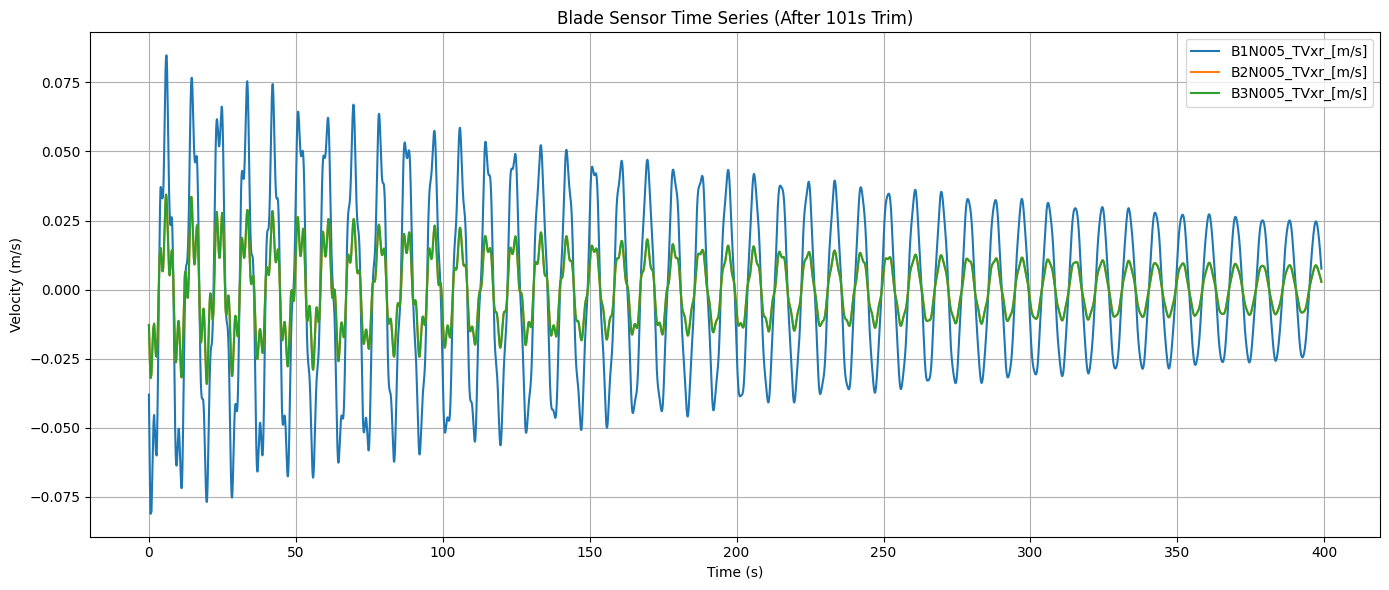

In [52]:
# Check if all three blade sensors are available in the data
blade_sensors = ['B1N005_TVxr_[m/s]', 'B2N005_TVxr_[m/s]', 'B3N005_TVxr_[m/s]']
available_sensors = [sensor for sensor in blade_sensors if sensor in trimmed_dataDF.columns]

print(f"Available blade sensors: {', '.join(available_sensors)}")

if len(available_sensors) > 0:
    # Plot time series of all available blade sensors
    plt.figure(figsize=(14, 6))
    for sensor in available_sensors:
        plt.plot(trimmed_dataDF['Time_[s]'], trimmed_dataDF[sensor], label=sensor)
        
    plt.title("Blade Sensor Time Series (After 101s Trim)")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No blade sensors found in the dataset! Available columns:")
    print(trimmed_dataDF.columns.tolist())

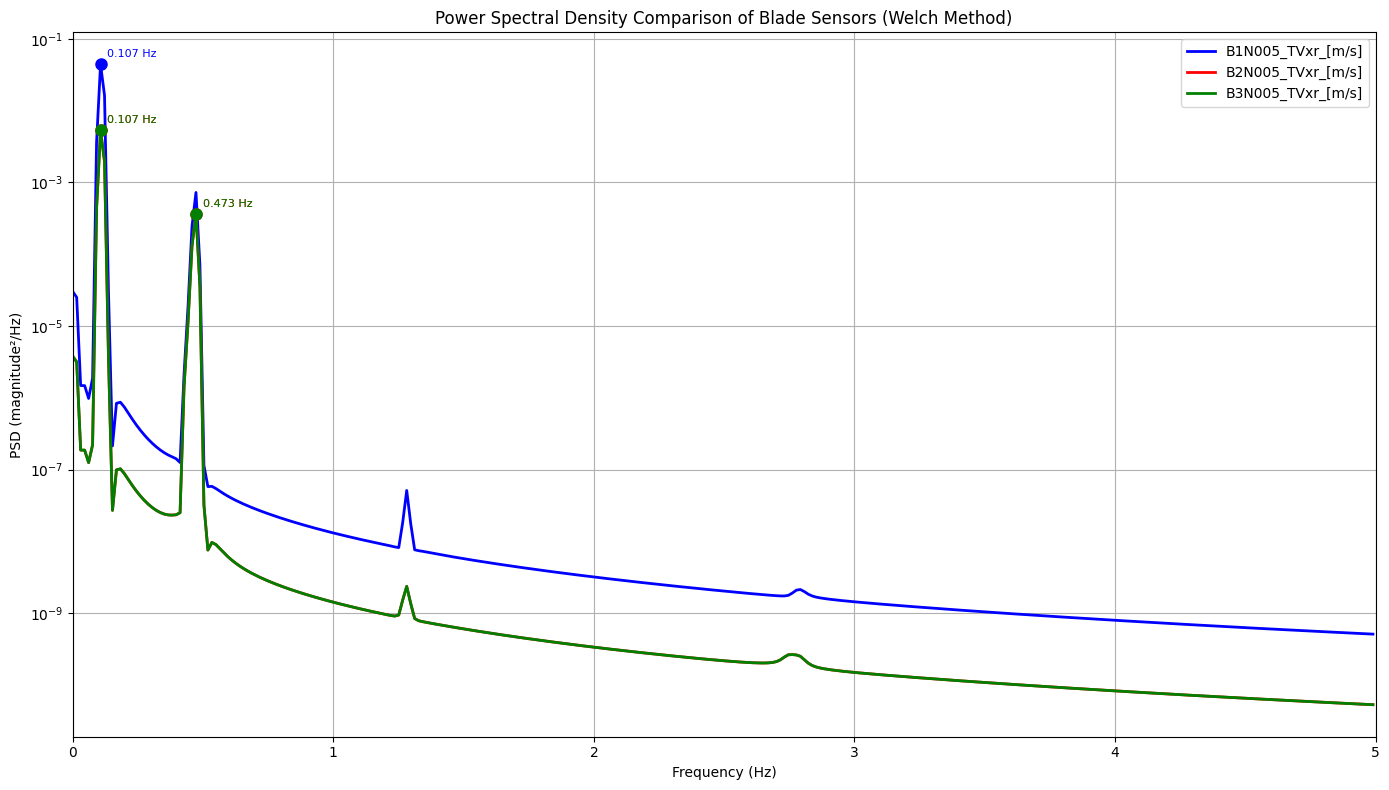

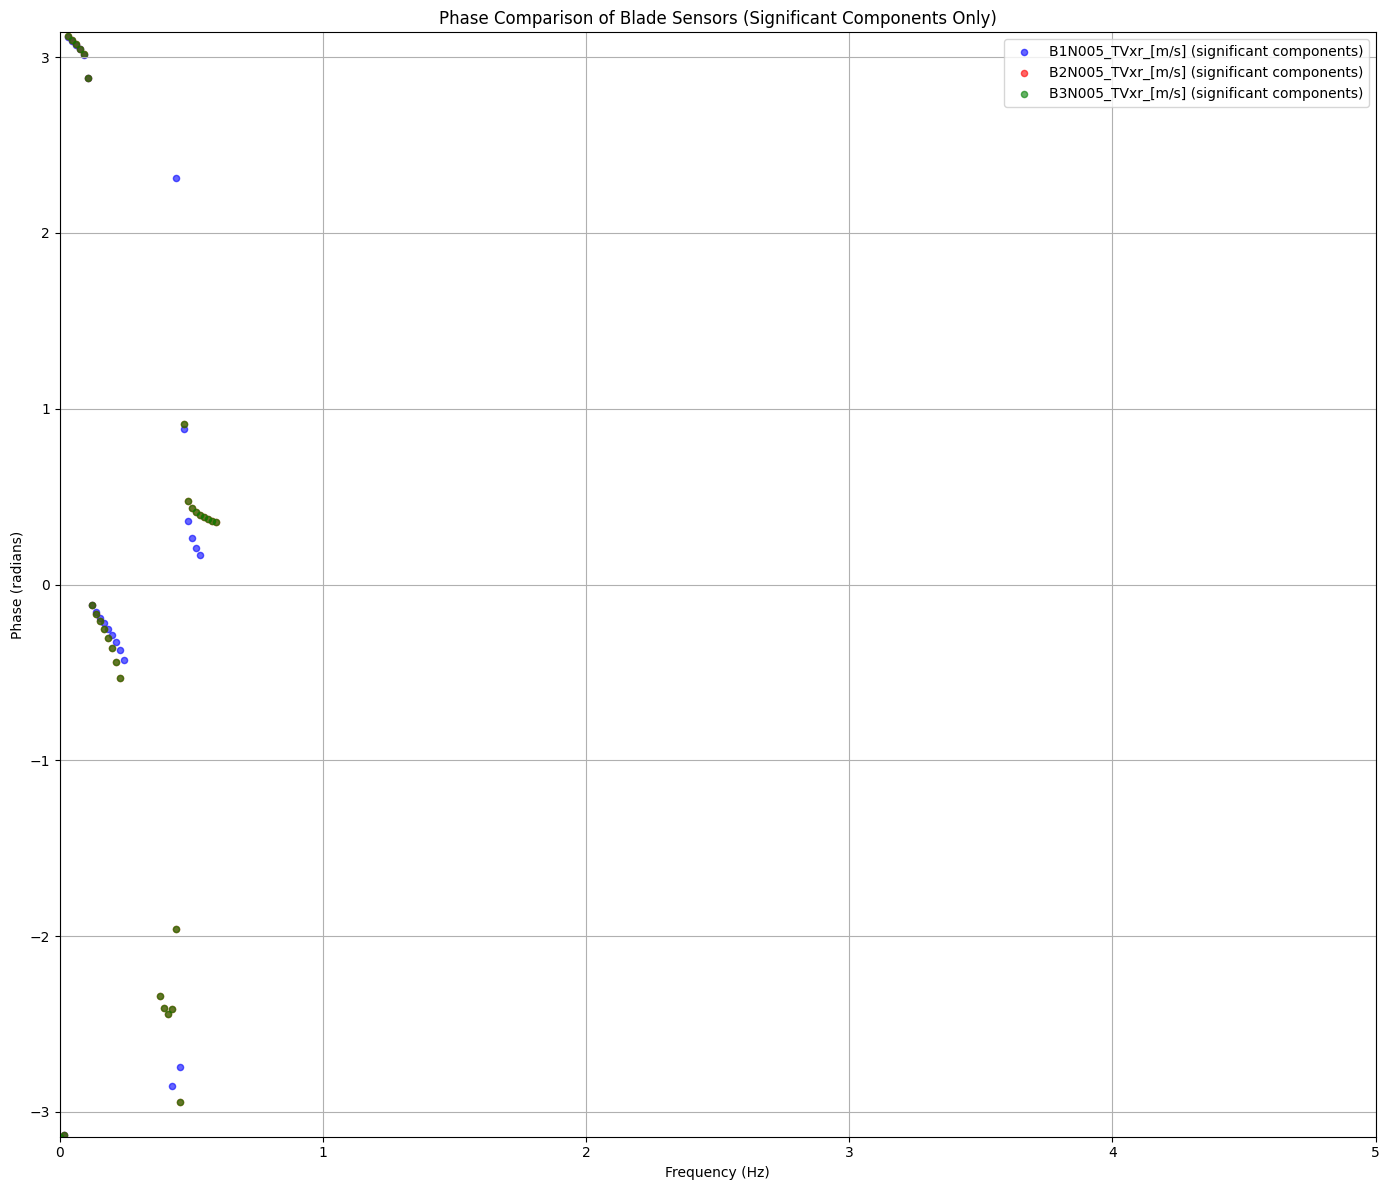

In [53]:
# Perform spectral analysis on all available blade sensors
from scipy import signal

if len(available_sensors) > 0:
    # Calculate sampling frequency
    fs = 1 / 0.001  # Assuming 0.001s time step as before
    
    # Set up the figure for PSD comparison
    plt.figure(figsize=(14, 8))
    
    # Define colors for consistent plotting
    colors = ['b', 'r', 'g']
    
    # Process each sensor
    for i, sensor in enumerate(available_sensors):
        # Extract and detrend the signal
        signal_data = np.array(trimmed_dataDF[sensor])
        detrended_data = signal.detrend(signal_data)
        
        # Calculate PSD using Welch method with Hamming window
        nperseg = min(2**16, len(detrended_data))
        frequencies, psd = signal.welch(detrended_data, fs=fs, window='hamming',
                                     nperseg=nperseg, scaling='density')
        
        # Filter frequencies below 5 Hz
        mask = frequencies <= 5.0
        freq_filtered = frequencies[mask]
        psd_filtered = psd[mask]
        
        # Plot the PSD for this sensor
        plt.semilogy(freq_filtered, psd_filtered, color=colors[i], label=sensor, linewidth=2)
        
        # Find peaks for this sensor
        prominence = 0.05 * np.max(psd_filtered)
        peaks, _ = signal.find_peaks(psd_filtered, prominence=prominence)
        
        # Mark and label the peaks
        for peak in peaks:
            plt.plot(freq_filtered[peak], psd_filtered[peak], 'o', color=colors[i], markersize=8)
            plt.annotate(f"{freq_filtered[peak]:.3f} Hz",
                        xy=(freq_filtered[peak], psd_filtered[peak]),
                        xytext=(5, 5), textcoords='offset points',
                        color=colors[i], fontsize=8)
    
    plt.title("Power Spectral Density Comparison of Blade Sensors (Welch Method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (magnitude²/Hz)")
    plt.grid(True, which="both", ls="-")
    plt.xlim(0, 5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create a phase comparison plot
    plt.figure(figsize=(14, 12))
    
    # Process each sensor for phase information
    for i, sensor in enumerate(available_sensors):
        # Extract and detrend the signal
        signal_data = np.array(trimmed_dataDF[sensor])
        detrended_data = signal.detrend(signal_data)
        
        # Compute FFT for phase information
        n_fft = min(2**16, len(detrended_data))
        fft_result = fft.fft(detrended_data, n=n_fft)
        fft_freqs = fft.fftfreq(n_fft, d=1/fs)
        fft_phase = np.angle(fft_result)
        
        # Convert to PSD for magnitude reference
        frequencies, psd = signal.welch(detrended_data, fs=fs, window='hamming',
                                     nperseg=n_fft, scaling='density')
        
        # Filter to positive frequencies below 5 Hz
        pos_mask = fft_freqs >= 0
        phase_mask = fft_freqs <= 5.0
        filter_mask = pos_mask & phase_mask
        
        # Find significant components
        magnitude = np.abs(fft_result)
        pos_magnitude = magnitude[pos_mask]
        threshold = 0.01 * np.max(pos_magnitude)
        significant_mask = pos_magnitude > threshold
        
        # Create a mask for positive frequencies with significant magnitude
        plot_mask = np.zeros_like(fft_freqs, dtype=bool)
        plot_mask[pos_mask] = significant_mask
        plot_mask = plot_mask & phase_mask
        
        # Plot significant phase points as scatter plot
        plt.scatter(fft_freqs[plot_mask], fft_phase[plot_mask], 
                   s=20, alpha=0.6, label=f"{sensor} (significant components)",
                   color=colors[i])
    
    plt.title("Phase Comparison of Blade Sensors (Significant Components Only)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase (radians)")
    plt.grid(True)
    plt.xlim(0, 5)
    plt.ylim(-np.pi, np.pi)
    plt.legend()
    plt.tight_layout()
    plt.show()


Identified Peak Frequencies:
------------------------------------------------------------
Frequency (Hz) B1N005_TVxr_[m/s] B2N005_TVxr_[m/s] B3N005_TVxr_[m/s]
------------------------------------------------------------
         0.107         4.416e-02         5.303e-03         5.303e-03
         0.473               ---         3.686e-04         3.686e-04
------------------------------------------------------------


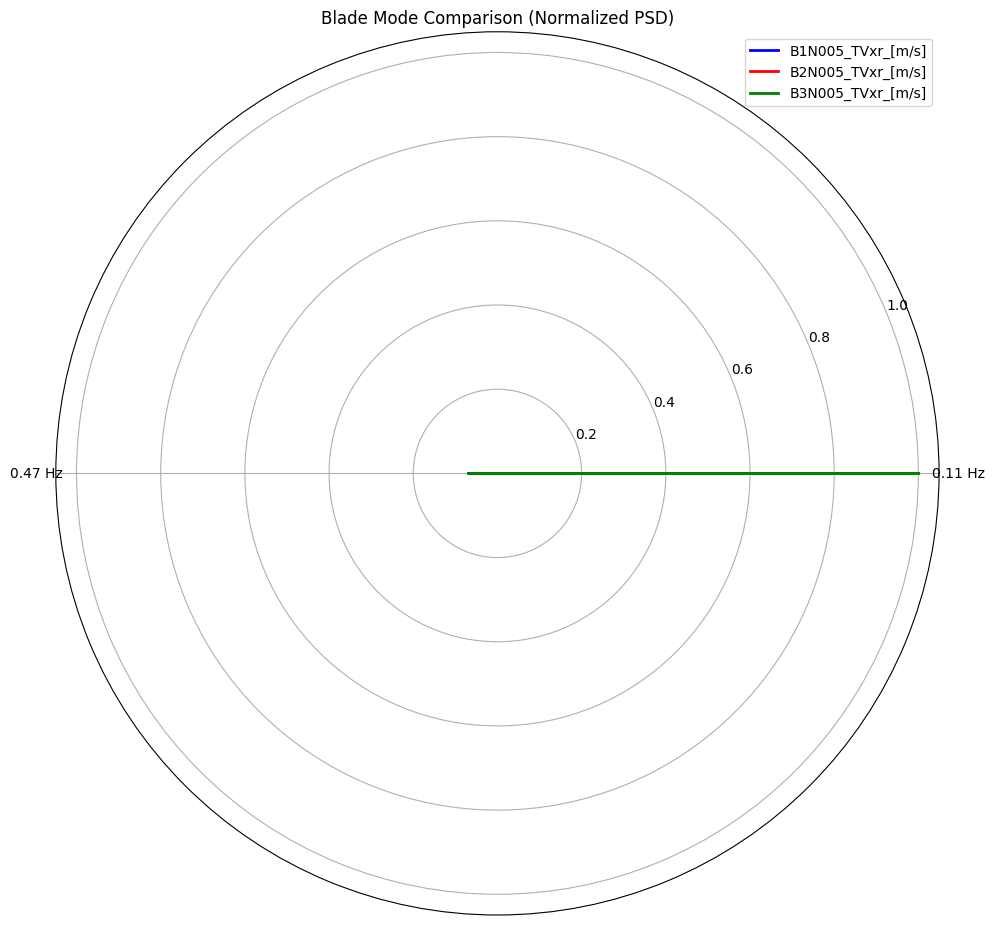

In [ ]:
# Create a combined plot showing all three blades with peak identification
if len(available_sensors) > 0:
    # Calculate the PSD for all sensors and store results
    sensor_data = []
    
    for sensor in available_sensors:
        # Process the signal
        signal_data = np.array(trimmed_dataDF[sensor])
        detrended_data = signal.detrend(signal_data)
        
        # Calculate PSD using Welch method
        nperseg = min(2**16, len(detrended_data))
        frequencies, psd = signal.welch(detrended_data, fs=fs, window='hamming',
                                     nperseg=nperseg, scaling='density')
        
        # Filter frequencies below 5 Hz
        mask = frequencies <= 5.0
        freq_filtered = frequencies[mask]
        psd_filtered = psd[mask]
        
        # Find peaks
        prominence = 0.05 * np.max(psd_filtered)
        peaks, properties = signal.find_peaks(psd_filtered, prominence=prominence)
        
        # Store data for this sensor
        sensor_data.append({
            'name': sensor,
            'freq': freq_filtered,
            'psd': psd_filtered,
            'peaks': peaks,
            'peak_freqs': freq_filtered[peaks],
            'peak_psd': psd_filtered[peaks]
        })
    
    # Create a table of identified peak frequencies
    print("\nIdentified Peak Frequencies:")
    print("-" * 60)
    header = "Frequency (Hz)" + "".join([f"{sensor:>18}" for sensor in available_sensors])
    print(header)
    print("-" * 60)
    
    # Collect all unique peak frequencies across all sensors
    all_peak_freqs = np.sort(np.unique(np.concatenate([data['peak_freqs'] for data in sensor_data])))
    
    # For each unique frequency, check if each sensor has a peak near it
    for freq in all_peak_freqs:
        row = [f"{freq:.3f}"]
        
        for data in sensor_data:
            # Check if this sensor has a peak within 0.01 Hz of this frequency
            peak_idx = np.argmin(np.abs(data['peak_freqs'] - freq))
            if np.abs(data['peak_freqs'][peak_idx] - freq) < 0.01:
                # Has a matching peak
                row.append(f"{data['peak_psd'][peak_idx]:.3e}")
            else:
                row.append("---")
        
        print(f"{row[0]:>14}" + "".join([f"{val:>18}" for val in row[1:]]))
    
    print("-" * 60)
    
    # Create a radar chart of peak frequencies to compare modes across blades
    if len(all_peak_freqs) > 0 and len(available_sensors) >= 2:
        from matplotlib.pyplot import figure, polar, grid, legend, show
        import matplotlib.pyplot as plt
        
        # Set up the figure for the radar chart
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, polar=True)
        
        # Set the angles for each frequency (evenly distributed around the circle)
        angles = np.linspace(0, 2*np.pi, len(all_peak_freqs), endpoint=False).tolist()
        
        # Make the chart a full circle by repeating the first angle
        angles += angles[:1]
        
        # Add frequency labels around the chart
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f"{f:.2f} Hz" for f in all_peak_freqs])
        
        # Plot each sensor as a different line on the radar chart
        for i, data in enumerate(sensor_data):
            # For each frequency, get the corresponding PSD value
            values = []
            
            for freq in all_peak_freqs:
                # Find the closest frequency in the data
                idx = np.argmin(np.abs(data['freq'] - freq))
                # Get the PSD value
                values.append(data['psd'][idx])
            
            # Normalize values for better visualization
            values_normalized = values / np.max(values)
            
            # Close the loop by repeating the first value
            values_normalized = np.append(values_normalized, values_normalized[0])
            
            # Plot the data
            ax.plot(angles, values_normalized, linewidth=2, label=data['name'], color=colors[i])
            ax.fill(angles, values_normalized, alpha=0.1, color=colors[i])
        
        ax.set_title("Blade Mode Comparison (Normalized PSD)")
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Combined Magnitude and Phase Plots for All Blade Sensors

Let's create a plot that shows both magnitude (PSD) and phase for each blade sensor side by side:

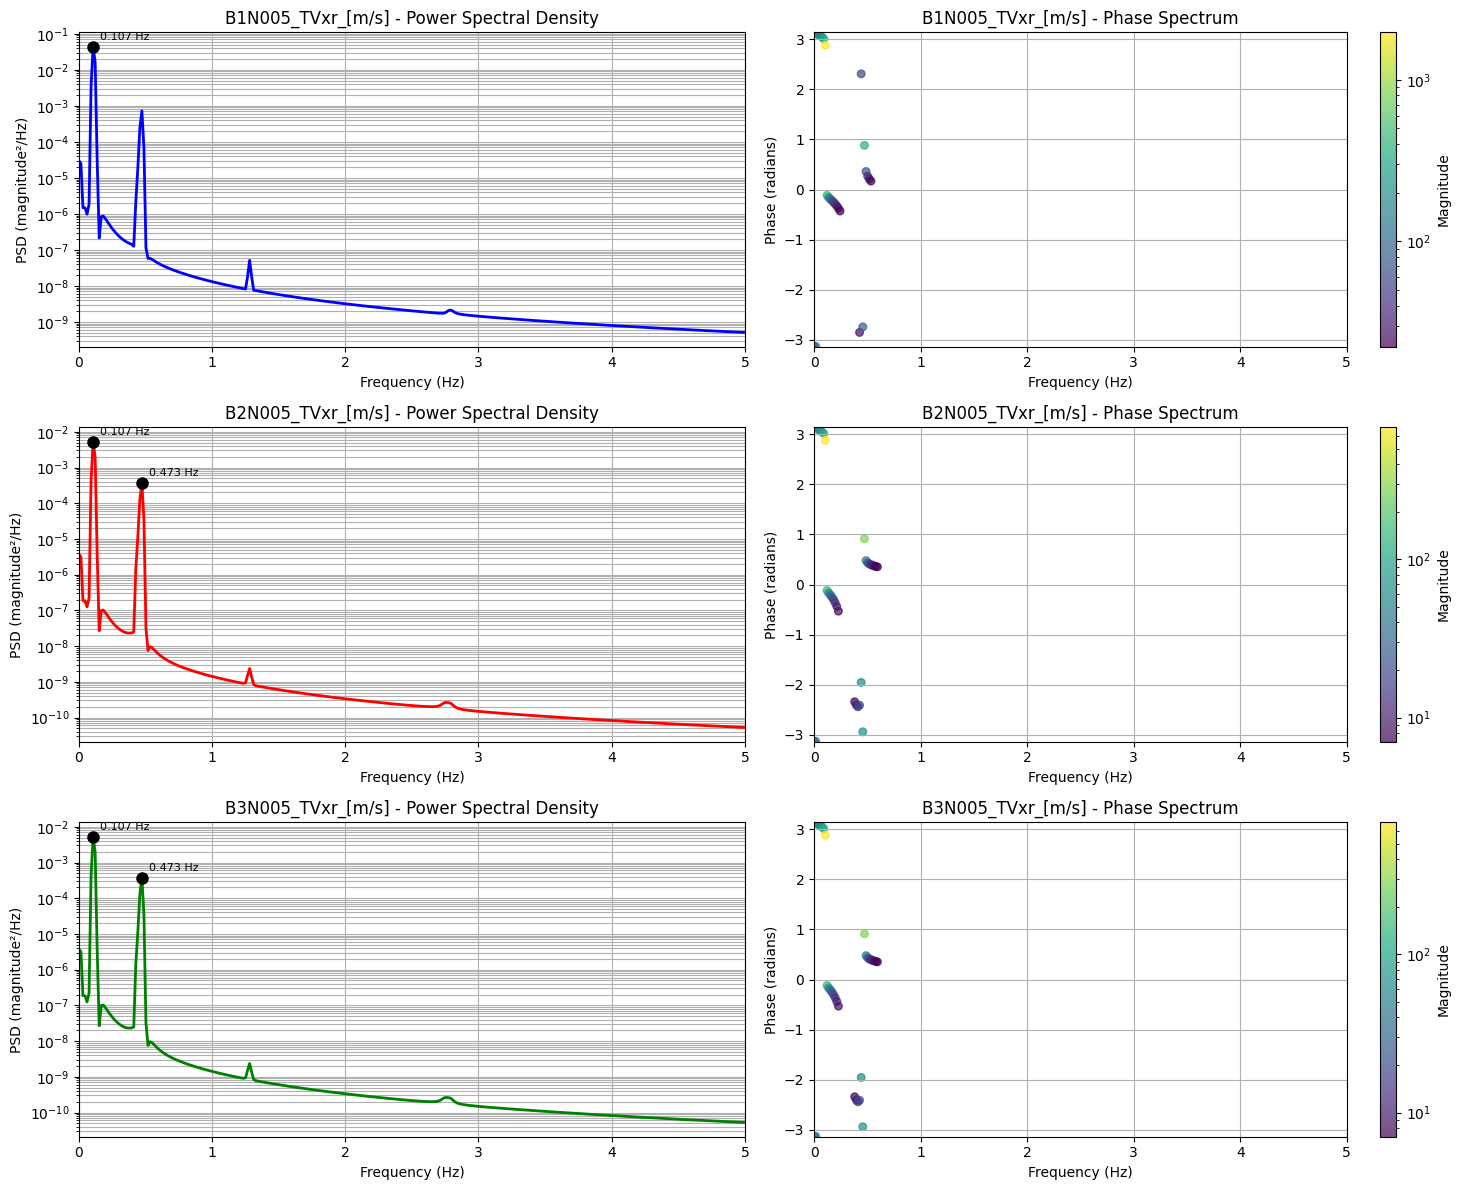

In [55]:
# Create combined magnitude and phase plots for all blade sensors
if len(available_sensors) > 0:
    # Set up the figure - one row per sensor, two columns (magnitude and phase)
    fig, axs = plt.subplots(len(available_sensors), 2, figsize=(15, 4*len(available_sensors)))
    
    # If there's only one sensor, axs will be 1D, convert to 2D for consistent indexing
    if len(available_sensors) == 1:
        axs = axs.reshape(1, 2)
    
    # Colors for consistent identification
    colors = ['b', 'r', 'g']
    
    # Process each sensor
    for i, sensor in enumerate(available_sensors):
        # Extract and detrend the signal
        signal_data = np.array(trimmed_dataDF[sensor])
        detrended_data = signal.detrend(signal_data)
        
        # Calculate PSD using Welch method
        nperseg = min(2**16, len(detrended_data))
        frequencies, psd = signal.welch(detrended_data, fs=fs, window='hamming',
                                     nperseg=nperseg, scaling='density')
        
        # Calculate FFT for phase information
        fft_result = fft.fft(detrended_data, n=nperseg)
        fft_freqs = fft.fftfreq(nperseg, d=1/fs)
        fft_phase = np.angle(fft_result)
        fft_magnitude = np.abs(fft_result)
        
        # Filter for frequencies below 5 Hz
        freq_mask = frequencies <= 5.0
        freq_filtered = frequencies[freq_mask]
        psd_filtered = psd[freq_mask]
        
        # Filter FFT results for frequencies below 5 Hz and positive only
        fft_mask = (fft_freqs >= 0) & (fft_freqs <= 5.0)
        fft_freqs_filtered = fft_freqs[fft_mask]
        fft_phase_filtered = fft_phase[fft_mask]
        fft_magnitude_filtered = fft_magnitude[fft_mask]
        
        # Find significant components for phase (to avoid noisy phase plot)
        sig_threshold = 0.01 * np.max(fft_magnitude_filtered)
        sig_mask = fft_magnitude_filtered > sig_threshold
        
        # Find peaks for this sensor
        prominence = 0.05 * np.max(psd_filtered)
        peaks, _ = signal.find_peaks(psd_filtered, prominence=prominence)
        
        # Plot magnitude (PSD)
        axs[i, 0].semilogy(freq_filtered, psd_filtered, color=colors[i], linewidth=2)
        axs[i, 0].set_title(f"{sensor} - Power Spectral Density")
        axs[i, 0].set_xlabel("Frequency (Hz)")
        axs[i, 0].set_ylabel("PSD (magnitude²/Hz)")
        axs[i, 0].grid(True, which="both", ls="-")
        axs[i, 0].set_xlim(0, 5)
        
        # Mark and label peaks on magnitude plot
        for peak in peaks:
            axs[i, 0].plot(freq_filtered[peak], psd_filtered[peak], 'o', 
                         color='k', markersize=8)
            axs[i, 0].annotate(f"{freq_filtered[peak]:.3f} Hz", 
                             xy=(freq_filtered[peak], psd_filtered[peak]),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # Plot phase (for significant components only)
        sc = axs[i, 1].scatter(fft_freqs_filtered[sig_mask], fft_phase_filtered[sig_mask],
                            c=fft_magnitude_filtered[sig_mask], cmap='viridis', 
                            s=30, alpha=0.7, norm=plt.matplotlib.colors.LogNorm())
        axs[i, 1].set_title(f"{sensor} - Phase Spectrum")
        axs[i, 1].set_xlabel("Frequency (Hz)")
        axs[i, 1].set_ylabel("Phase (radians)")
        axs[i, 1].grid(True)
        axs[i, 1].set_xlim(0, 5)
        axs[i, 1].set_ylim(-np.pi, np.pi)
        
        # Add a colorbar for the phase plot
        plt.colorbar(sc, ax=axs[i, 1], label='Magnitude')
        
    plt.tight_layout()
    plt.show()